# Twitter Data Sentiment Analysis

In [2]:
import pandas as pd
import numpy as np
import re 
import nltk 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Importing Dataset

In [4]:
train_data = pd.read_csv('./train_tweets.csv',encoding='latin1')
train_data

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂ...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [5]:
test_data = pd.read_csv('./test_tweets.csv',encoding='latin1')
test_data

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid Ã°ÂÂÂ #hairflip #nev...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


In [6]:
print('Training Set Shape = {}'.format(train_data.shape))
print('Test Set Shape = {}'.format(test_data.shape))

Training Set Shape = (31962, 3)
Test Set Shape = (17197, 2)


### Converting Categorical Labels to Numeric Labels

### Removing URLs and HTML from Tweets

In [7]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
train_data['tweet']=train_data['tweet'].apply(lambda x:remove_urls(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train_data['tweet']=train_data['tweet'].apply(lambda x:remove_html(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:remove_html(x))

### Converting the Tweet text to lowercase

In [8]:
def lower(text):
    low_text= text.lower()
    return low_text
train_data['tweet']=train_data['tweet'].apply(lambda x:lower(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:lower(x))

### Removing numerical values from Tweet text

In [9]:
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
train_data['tweet']=train_data['tweet'].apply(lambda x:remove_num(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:remove_num(x))

### Removing Punctuation and Stopwords

In [10]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
train_data['tweet']=train_data['tweet'].apply(lambda x:punct_remove(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:punct_remove(x))

In [11]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
train_data['tweet']=train_data['tweet'].apply(lambda x:remove_stopwords(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:remove_stopwords(x))

### Removing @ Mentions, # Hashtags, and Spaces

In [12]:
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
train_data['tweet']=train_data['tweet'].apply(lambda x:remove_mention(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
train_data['tweet']=train_data['tweet'].apply(lambda x:remove_hash(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:remove_hash(x))

def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
train_data['tweet']=train_data['tweet'].apply(lambda x:remove_space(x))
test_data['tweet']=test_data['tweet'].apply(lambda x:remove_space(x))


### Preprocessed Data

In [13]:
train_data

,id,label,tweet
0,1,0,user father dysfunctional selfish drags kids d...
1,2,0,user user thanks lyft credit cant use cause do...
2,3,0,bihday majesty
3,4,0,model love u take u time urãâââ ãâââãâââãâââãâ...
4,5,0,factsguide society motivation
...,...,...,...
31957,31958,0,ate user isz youuuãâââãâââãâââãâââãâââãâââãâââ...
31958,31959,0,see nina turner airwaves trying wrap mantle ge...
31959,31960,0,listening sad songs monday morning otw work sad
31960,31961,1,user sikh temple vandalised calgary wso condem...


In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_data.tweet, train_data.label, test_size=0.33, random_state=42)

### TF-IDF

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')

train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)

## Classifier #1: Multinomial Naive Bayes

In [16]:
nb = MultinomialNB()
nb.fit(train_tfidf, y_train)
nb_model = nb.predict(test_tfidf)

accuracy_score(y_test, nb_model)

0.950322335987865

<AxesSubplot:>

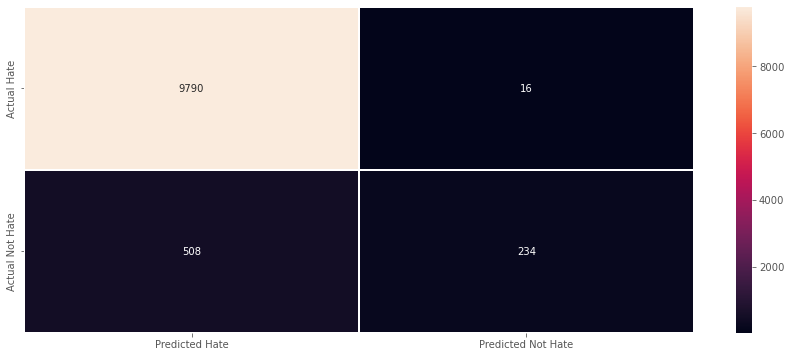

In [17]:
nb_conf = confusion_matrix(y_test, nb_model)
ylabel = ["Actual Hate","Actual Not Hate"]
xlabel = ["Predicted Hate","Predicted Not Hate"] 
plt.figure(figsize=(15,6))
sns.heatmap(nb_conf, annot=True, xticklabels = xlabel, yticklabels = ylabel, linewidths=1, fmt='g')

## Classifier #2: Linear Support Vector

In [18]:
lsvc = LinearSVC()
lsvc.fit(train_tfidf, y_train)
lsvc_model = lsvc.predict(test_tfidf)

accuracy_score(y_test, lsvc_model)

0.9567690557451649

<AxesSubplot:>

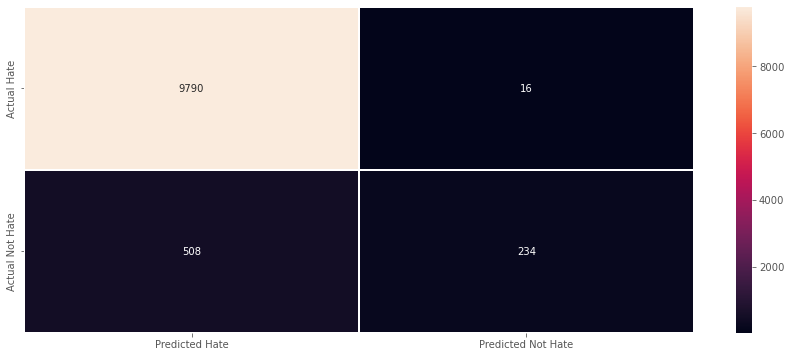

In [19]:
lsvc_conf = confusion_matrix(y_test, nb_model)
ylabel = ["Actual Hate","Actual Not Hate"]
xlabel = ["Predicted Hate","Predicted Not Hate"] 
plt.figure(figsize=(15,6))
sns.heatmap(lsvc_conf, annot=True, xticklabels = xlabel, yticklabels = ylabel, linewidths=1, fmt='g')

## Classifier #3: Random Forest

In [20]:
rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(train_tfidf, y_train)
rfc_model = rfc.predict(test_tfidf)

accuracy_score(y_test, rfc_model)

0.9549677664012135

<AxesSubplot:>

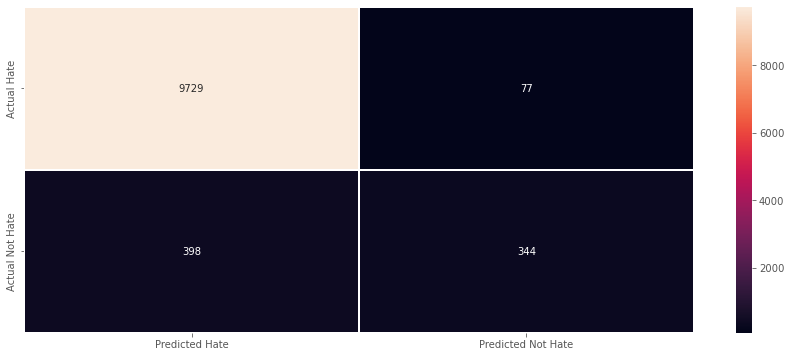

In [21]:
rfc_conf = confusion_matrix(y_test, rfc_model)
ylabel = ["Actual Hate","Actual Not Hate"]
xlabel = ["Predicted Hate","Predicted Not Hate"] 
plt.figure(figsize=(15,6))
sns.heatmap(rfc_conf, annot=True, xticklabels = xlabel, yticklabels = ylabel, linewidths=1, fmt='g')